## RAD HARD Analytics
<em> Manufacturer & Performance Visualizations </em>

In [1]:
import pandas as pd, numpy as np
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sqlalchemy import create_engine
import psycopg2
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sns.set(rc={'figure.figsize':(15,10)})
pd.set_option('max_columns',50)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
connect = psycopg2.connect(host='crane-rad-hard-instance-1.csic2ytpqp5y.us-east-1.rds.amazonaws.com',
                           user='postgres', password='f5NBBNwPD6hawm$GCRMj', dbname='radhard_poc', port=5432)
cur = connect.cursor()

In [3]:
# cur.close()
# connect.close()

### Part Performance Trends by Part Category

In [4]:
datData = pd.DataFrame()
i = 0
datDataPath = '/home/ec2-user/SageMaker/cleaning/result_csv/datDataClean.csv'
for chunk in pd.read_csv(datDataPath, chunksize=10000):
    x = random.random()
    i += 1
    print('\ron chunk {0}'.format(i), end='')
    if x < .30:
        chunk = chunk[['drmFile', 'lot', 'sn', 'SCD', 'deviceType', 'partIsAnalog',
                       'measureval', 'lowlimit', 'highlimit', 'g', 
                       'deviceManufacturer', 'testDate']]
        chunk = chunk[~pd.isna(chunk.lowlimit)]
        chunk['deviceType'] = chunk.apply(lambda r: r['deviceType'] + ' (analog)' if r['partIsAnalog'] == 1 else r['deviceType'], axis=1)
        chunk.drop('partIsAnalog', axis=1, inplace=True)
        chunk['distLowLimit'] = (chunk['measureval'] - chunk['lowlimit'])/(chunk['highlimit'] - chunk['lowlimit'])
        chunk['testYear'] = chunk['testDate'].apply(lambda x: pd.to_datetime(x).year )
        datData = pd.concat([datData, chunk])
    else:
        continue
print('\n')
print('number of records loaded:', len(datData))
datData.head()

on chunk 897

number of records loaded: 2263270


,drmFile,lot,sn,SCD,deviceType,measureval,lowlimit,highlimit,g,deviceManufacturer,testDate,distLowLimit,testYear
30000,GDZ036RSV-03Test-5.dat,GDZ036RSV-03,9455,5672986-101,microcircuit,1.395,0.9,2.5,G,honeywell,2020-11-30,0.309375,2020
30001,GDZ036RSV-03Test-5.dat,GDZ036RSV-03,9455,5672986-101,microcircuit,1.395,0.9,2.5,G,honeywell,2020-11-30,0.309375,2020
30002,GDZ036RSV-03Test-5.dat,GDZ036RSV-03,9455,5672986-101,microcircuit,1.395,0.9,2.5,G,honeywell,2020-11-30,0.309375,2020
30003,GDZ036RSV-03Test-5.dat,GDZ036RSV-03,9455,5672986-101,microcircuit,1.385,0.9,2.5,G,honeywell,2020-11-30,0.303125,2020
30004,GDZ036RSV-03Test-5.dat,GDZ036RSV-03,9455,5672986-101,microcircuit,1.395,0.9,2.5,G,honeywell,2020-11-30,0.309375,2020


In [5]:
datData = pd.read_csv('result_csv/performance.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



In [6]:
cur.execute('''
SELECT * 
FROM 
(
    SELECT DISTINCT dat_file_name, lot_no, sn, scd_number, device_mfr,
        CASE WHEN analog_part_ind = '1' then dat_device_type||' (analog)' else dat_device_type end as deviceType,
        CAST(measure_val as FLOAT), CAST(lower_limit as FLOAT), CAST(upper_limit as FLOAT), test_comments, CAST(test_dt as DATE),
        row_number() OVER (PARTITION BY CASE WHEN analog_part_ind = '1' then dat_device_type||' (analog)' else dat_device_type end ORDER BY random()) as rn
    FROM "Raw"."Dat_Data_Cleansed"
    WHERE (lower_limit IS NOT NULL and upper_limit IS NOT NULL) or (test_comments IS NOT NULL)
) foo
WHERE rn < 100000
''')
datData = cur.fetchall()
datData = pd.DataFrame(datData)
datData.columns = ['drmFile', 'lot', 'sn', 'SCD', 'deviceManufacturer', 'deviceType', 'measureval', 
                   'lowlimit', 'highlimit', 'test_comments', 'testDate', 'rn']
print('number of records loaded:', len(datData))
datData.head()

number of records loaded: 756074


,drmFile,lot,sn,SCD,deviceManufacturer,deviceType,measureval,lowlimit,highlimit,test_comments,testDate,rn
0,GDT009IE_long_control.dat.dat,QLP014CTRL,60,5672969-101,honeywell,amplifier,2.000000e-03,NaN,NaN,"OUT Open_Loop,Vee_load Lim= -5E-3 125E-3 V",2009-11-16,7720
1,GDT009IE_Combined.dat,GDT009IE,367,7142354-101,honeywell,amplifier,1.416400e-07,NaN,NaN,A_OUT Follower_Configuration Lim= 0 1000E-9 s,2009-11-16,3035
2,GDD005RNT-16_Group1_Step-16_control.dat,QLP015CTRL,8,5672969-101,honeywell,amplifier,6.287000e-03,NaN,NaN,DUT Follower Lim= 0 10E-3 A,2012-02-16,9534
3,A_QLP015RDR.dat,QLP015RDR,174,5672969-101,honeywell,amplifier,0.000000e+00,NaN,NaN,"OUT Open_Loop,Vee_load Lim= -5E-3 125E-3 V",2009-06-10,8022
4,GDT009RNT_Group1_Post-TID_ATE_Long_control.dat,QLP015CTRL,8,7142354-101,honeywell,amplifier,1.446689e+02,NaN,NaN,"IN+_A_IN-_ Vin_0.25_4.75V,Servo_Loop_Gain=1001...",2010-04-27,10034


In [7]:
def getLimits(x):
    if "Lim=" in x:
        x = x.split('Lim=')[1]
        out = re.findall('[\d\-eE\.]+', x)
        try:
            out = [np.NaN if z == '-' else float(z) for z in out]
        except:
            return np.NaN, np.NaN
        return out
    else:
        return np.NaN, np.NaN

In [8]:
datData['lowlimit'] = datData.apply(lambda r: r['lowlimit'] 
                                    if pd.isna(r['lowlimit']) == np.NaN 
                                    else getLimits(r['test_comments'])[0], axis=1)

In [9]:
datData['highlimit'] = datData.apply(lambda r: r['highlimit'] 
                                     if pd.isna(r['highlimit']) == np.NaN 
                                     else getLimits(r['test_comments'])[1], axis=1)

In [10]:
datData['distLowLimit'] = (datData['measureval'] - datData['lowlimit'])/(datData['highlimit'] - datData['lowlimit'])

In [11]:
datData = datData[datData['distLowLimit'] < 3]
datData = datData[datData['distLowLimit'] > -3]

Text(0.5, 1.0, 'Part Performance Trends by Part Category')

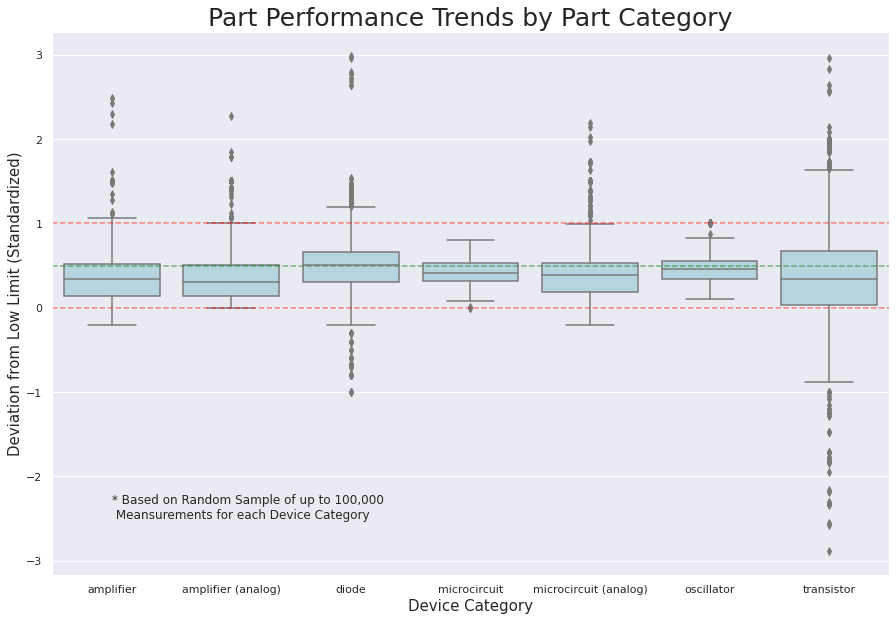

In [12]:
p = sns.boxplot(x='deviceType', y='distLowLimit', 
                data=datData, color='LightBlue', saturation=0.7)
p.axhline(0.5, color='green', ls='--', alpha=.5)
p.axhline(1, color='red', ls='--', alpha=.5)
p.axhline(0, color='red', ls='--', alpha=.5)
p.set_xlabel("Device Category", fontsize = 15)
p.set_ylabel("Deviation from Low Limit (Standardized)", fontsize = 15)
p.text(0, -2.5, "* Based on Random Sample of up to 100,000 \n Meansurements for each Device Category")

p.set_title("Part Performance Trends by Part Category", fontsize = 25)

### Part Performance Trends by Manufacturer

In [13]:
len(datData)

332638

Text(0.5, 1.0, 'Part Performance Trends by Manufacturer')

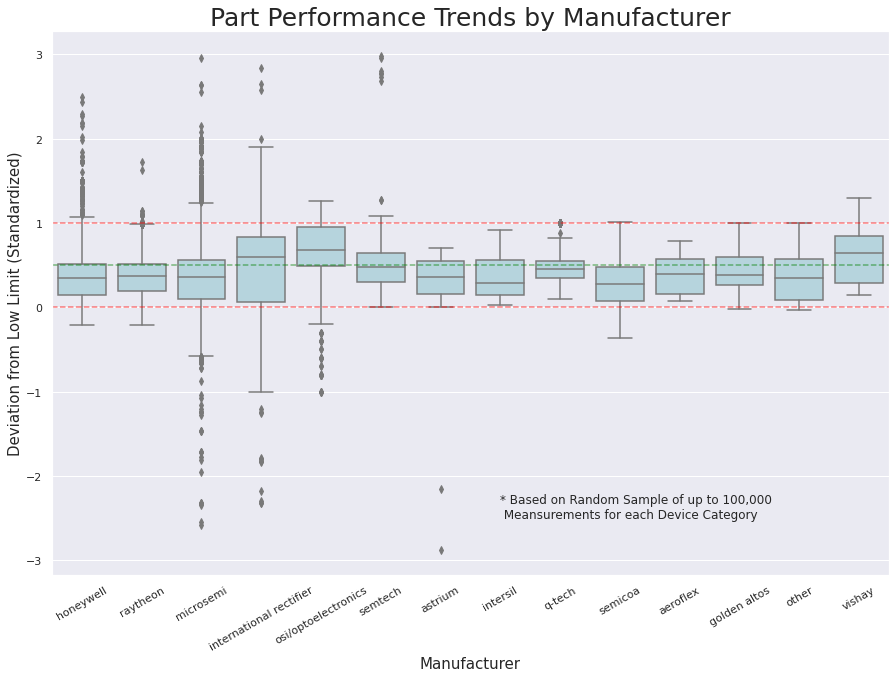

In [14]:
p = sns.boxplot(x='deviceManufacturer', y='distLowLimit', 
                data=datData, color='LightBlue', saturation=0.7)
p.axhline(0.5, color='green', ls='--', alpha=.5)
p.axhline(1, color='red', ls='--', alpha=.5)
p.axhline(0, color='red', ls='--', alpha=.5)
p.set_xlabel("Manufacturer", fontsize = 15)
p.set_xticklabels(p.get_xticklabels(),rotation=30)
p.set_ylabel("Deviation from Low Limit (Standardized)", fontsize = 15)
p.text(7, -2.5, "* Based on Random Sample of up to 100,000 \n Meansurements for each Device Category")

p.set_title("Part Performance Trends by Manufacturer", fontsize = 25)

### Variation in Performance Over Time by Manufacturer

In [15]:
datData2 = pd.DataFrame()
i = 0
datDataPath = '/home/ec2-user/SageMaker/cleaning/result_csv/datDataClean.csv'
for chunk in pd.read_csv(datDataPath, chunksize=10000):
    x = random.random()
    i += 1
    print('\ron chunk {0}'.format(i), end='')
    if x < .10:
        chunk = chunk[['drmFile', 'lot', 'sn', 'SCD', 'deviceType', 'partIsAnalog',
                       'g', 'deviceManufacturer', 'testDate', 'ageTest']]
        chunk['deviceType'] = chunk.apply(lambda r: r['deviceType'] + ' (analog)' if r['partIsAnalog'] == 1 else r['deviceType'], axis=1)
        chunk.drop('partIsAnalog', axis=1, inplace=True)
        chunk['testYear'] = chunk['testDate'].apply(lambda x: pd.to_datetime(x).year )
        datData2 = pd.concat([datData2, chunk])
    else:
        continue
print('\n')
print('number of records loaded:', len(datData2))
datData2.head()

on chunk 897

number of records loaded: 840000


,drmFile,lot,sn,SCD,deviceType,g,deviceManufacturer,testDate,ageTest,testYear
190000,GDD092RSV-32Test6.dat,GDD092RSV-32,68864,5673095-141,memory,G,honeywell,2013-05-24,341 days,2013
190001,GDD092RSV-32Test6.dat,GDD092RSV-32,68864,5673095-141,memory,G,honeywell,2013-05-24,341 days,2013
190002,GDD092RSV-32Test6.dat,GDD092RSV-32,68864,5673095-141,memory,G,honeywell,2013-05-24,341 days,2013
190003,GDD092RSV-32Test6.dat,GDD092RSV-32,68864,5673095-141,memory,G,honeywell,2013-05-24,341 days,2013
190004,GDD092RSV-32Test6.dat,GDD092RSV-32,68864,5673095-141,memory,G,honeywell,2013-05-24,341 days,2013


In [16]:
cur.execute('''
SELECT dat_file_name, lot_no, sn, scd_number, device_mfr, deviceType, testDate, max(failInd) as failInd
FROM 
(
    SELECT DISTINCT dat_file_name, lot_no, sn, scd_number, device_mfr,
        CASE WHEN analog_part_ind = '1' then dat_device_type||' (analog)' else dat_device_type END AS deviceType,
        CASE WHEN test_pass_ind = 'F' then 1 else 0 END AS failInd, CAST(test_dt as DATE) as testDate
    FROM "Raw"."Dat_Data_Cleansed"
) foo
GROUP BY dat_file_name, lot_no, sn, scd_number, device_mfr, deviceType, testDate
''')
datData2 = cur.fetchall()
datData2 = pd.DataFrame(datData2)
datData2.columns = ['drmFile', 'lot', 'sn', 'SCD', 'deviceManufacturer', 'deviceType', 'testDate', 'failInd']
datData2['testYear'] = datData2['testDate'].apply(lambda x: pd.to_datetime(x).year )
print('number of records loaded:', len(datData2))
datData2.head()

number of records loaded: 42390


,drmFile,lot,sn,SCD,deviceManufacturer,deviceType,testDate,failInd,testYear
0,MIQ159RSV-04 TEST 5A @ AMB DATA-checkpoint.dat,None,197,5626755-101,microsemi,diode,2019-07-11,0,2019
1,GDD155RNE-02-TST7DreamFmt.dat,None,15,5673029-102,microsemi,diode,2011-07-29,0,2011
2,RYH001RNT-02_Test-3_control.dat,control,26,5672965-101,raytheon,microcircuit (analog),2013-06-18,1,2013
3,QLP071IE_055.dat,QLP071IE,6854,5673100-101,q-tech,oscillator,2009-02-24,0,2009
4,MIQ156RSV-06-TST9DREAMFMT (2).DAT,None,112,5624949-110,microsemi,diode,2017-06-13,0,2017


In [17]:
datData3 = datData2[datData2['failInd'] == 1] 
# datData3.head()

In [18]:
df = datData3[['testYear', 'deviceManufacturer']].value_counts().reset_index(name='fail_counts')
# df.head()

In [19]:
df2 = datData2[['testYear', 'deviceManufacturer']].value_counts().reset_index(name='test_counts')
# df2.head()

In [20]:
df_tests_and_fails = pd.merge(df, df2, how='left', 
                              left_on = ['testYear','deviceManufacturer'], 
                              right_on = ['testYear','deviceManufacturer'])
# df_tests_and_fails.head()

In [21]:
df_1 = df_tests_and_fails
df_1['failure_rate'] = df_1['fail_counts']/df_1['test_counts']
df_1.head()

,testYear,deviceManufacturer,fail_counts,test_counts,failure_rate
0,2010,microsemi,690,1912,0.360879
1,2016,microsemi,504,1851,0.272285
2,2011,microsemi,453,1487,0.304640
3,2012,microsemi,377,2342,0.160974
4,2012,honeywell,257,2597,0.098960


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



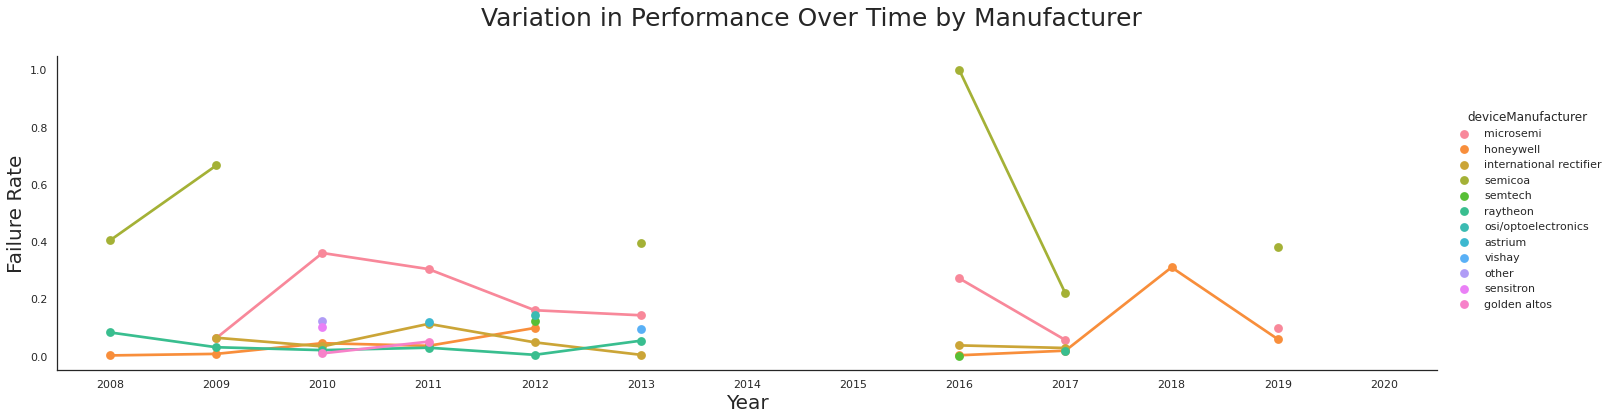

In [22]:
with sns.axes_style('white'):
    g = sns.factorplot("testYear", "failure_rate", data=df_1, aspect=4.0,
                       hue='deviceManufacturer', order=range(2008, 2021))
    g.set_xlabels('Year', fontsize = 20)
    g.set_ylabels('Failure Rate', fontsize = 20)
    g.fig.suptitle("Variation in Performance Over Time by Manufacturer", y = 1.1, fontsize = 25)

In [23]:
# A list of manufacturers that are going to be highlighted
HIGHLIGHTS = ["honeywell", "microsemi", "semicoa"]


# Subset variables
var_df = df_1[["deviceManufacturer", "testYear", "failure_rate"]]


# If there is more than one record per testYear/Manufacturer, use the mean
var_df_v2 = var_df.groupby(["deviceManufacturer", "testYear", "failure_rate"]).agg(
    failure_rate_mean = ("failure_rate", "mean")
).reset_index()


# Create 'group' to determine which ones are highlighted
var_df_v2["group"] = np.where(
    var_df_v2["deviceManufacturer"].isin(HIGHLIGHTS),
    var_df_v2["deviceManufacturer"],
    "other"
)


# Make 'group' categorical 
var_df_v2["group"] = pd.Categorical(
    var_df_v2["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

In [24]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # Semicoa
    "#11A579", # Honeywell
    "#3969AC"  # Microsemi
]

# Vertical lines every 5 years
VLINES = np.arange(2008, 2021, 1)

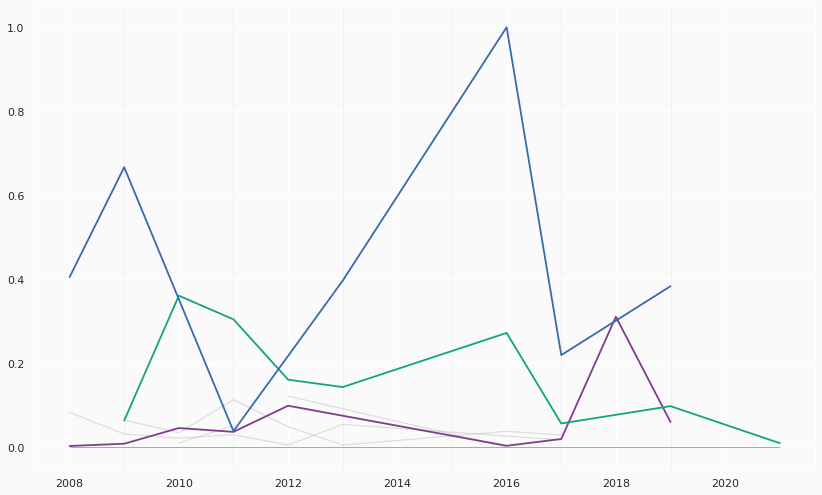

In [25]:
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 1), xmin=2008, xmax=2021, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2008, xmax=2021, color=GREY60, lw=0.8)


# Add lines ------------------------------------------------------
# Create one data frame for the highlighted countries, and other
# for non-highlighted countries.
df_highlight = var_df_v2[var_df_v2["group"] != "other"]
df_others = var_df_v2[var_df_v2["group"] == "other"]

for group in df_others["deviceManufacturer"].unique():
    data = df_others[df_others["deviceManufacturer"] == group]
    ax.plot("testYear", "failure_rate", c=GREY75, lw=1.2, alpha=0.5, data=data)

for idx, group in enumerate(df_highlight["deviceManufacturer"].unique()):
    data = df_highlight[df_highlight["deviceManufacturer"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("testYear", "failure_rate", color=color, lw=1.8, data=data)

In [26]:
# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Add titles, subtitles, and caption -----------------------------
# This uses `fig.text()` instead of regular titles to have full
# control of the text alignment.
subtitle = [
    "The line chart visualizes the performance in manufacturers over time based on their failure rate, calculated by their total number of failures divided by their total number of tests in a given year.",
    "The manufacturers with the greatest/most significant variance over time have been highlighted in color, while the remaining manufacturers have been plotted in gray for comparison. As the chart", 
    "indicates, the three highlighted manufacturers see much larger variations in performance over time than do a majority of part vendors.", 
]

fig.text(
    0.08,
    0.97,
    "Highlighted Performance Variations Over Time, by Manufacturer",
    color=GREY10,
    fontsize=15,
    fontname="Montserrat",
    weight="bold"
)

fig.text(
    0.08,
    0.91,
    "\n".join(subtitle),
    ha="left",
    color=GREY30,
    fontname="Montserrat",
    fontsize=9,
)

Text(0.08, 0.91, 'The line chart visualizes the performance in manufacturers over time based on their failure rate, calculated by their total number of failures divided by their total number of tests in a given year.\nThe manufacturers with the greatest/most significant variance over time have been highlighted in color, while the remaining manufacturers have been plotted in gray for comparison. As the chart\nindicates, the three highlighted manufacturers see much larger variations in performance over time than do a majority of part vendors.')

In [27]:
# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(2008, 2025)
ax.set_ylim(0, 1)

# Positions
LABEL_Y = [
    0.08, # Semicoa
    0.01, # Honeywell
    0.39  # Microsemi
    
]

x_start = 2021
x_end = 2022
PAD = 0.1

# Add labels for highlighted countries honly
for idx, group in enumerate(df_highlight["deviceManufacturer"].unique()):
    data = df_highlight[(df_highlight["deviceManufacturer"] == group) & (df_highlight["testYear"] == 2021)]
    color = COLOR_SCALE[idx]
    
    # Manufacturer name
    text1 = "Semicoa"
    text2 = "Honeywell"
    text3 = "Microsemi"
    
    text = [text1, text2, text3]
    
    # Vertical start of line
    y_start = var_df_v2["failure_rate"].values[0]
    # Vertical end of line
    y_end = LABEL_Y[idx]
    
    # Add country text
    ax.text(2022, 0.08, "Honeywell", color  = "#7F3C8D")
    ax.text(2022, 0.01, "Mircosemi", color = "#11A579")
    ax.text(2022, 0.39, "Semicoa", color = "#3969AC")

findfont: Font family ['Montserrat'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Montserrat'] not found. Falling back to DejaVu Sans.


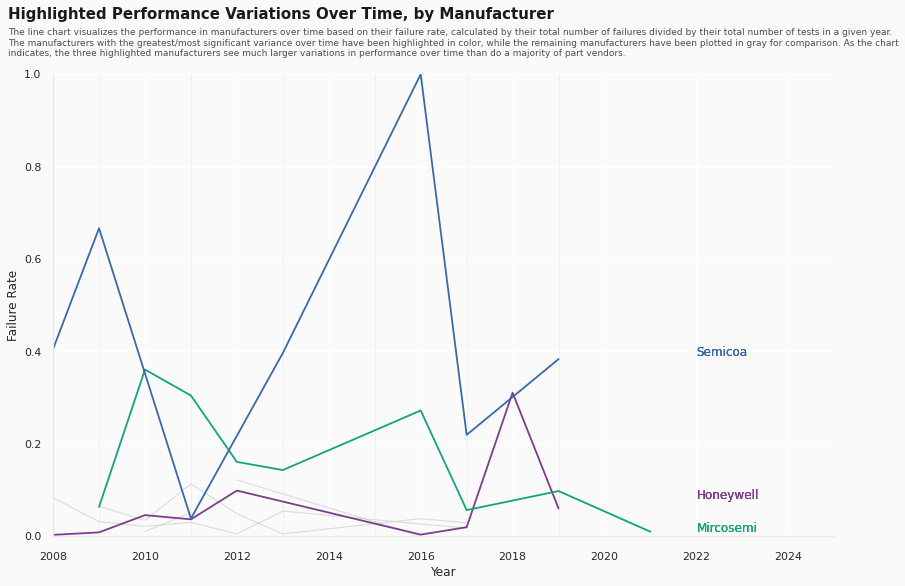

In [28]:
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Failure Rate', fontsize = 12)

fig

In [29]:
len(var_df_v2)

48

### Variation in Performance Over Time by Device Type

In [30]:
datData3 = datData2[datData2['failInd'] == 1] 
# datData3.head()

In [31]:
df = datData3[['testYear', 'deviceType']].value_counts().reset_index(name='fail_counts')
# df.head()

In [32]:
df2 = datData2[['testYear', 'deviceType']].value_counts().reset_index(name='test_counts')
# df2.head()

In [33]:
df_tests_and_fails = pd.merge(df, df2, how='left', 
                              left_on = ['testYear','deviceType'], 
                              right_on = ['testYear','deviceType'])
# df_tests_and_fails.head()

In [34]:
df_1 = df_tests_and_fails
df_1['failure_rate'] = df_1['fail_counts']/df_1['test_counts']
df_1.head()

,testYear,deviceType,fail_counts,test_counts,failure_rate
0,2010,transistor,716,2340,0.305983
1,2011,transistor,587,2307,0.254443
2,2016,transistor,508,1155,0.439827
3,2012,transistor,413,1843,0.224091
4,2013,transistor,355,1467,0.241990


In [35]:
# A list of manufacturers that are going to be highlighted
HIGHLIGHTS = ["transistor", "microcircuit", "memory"]


# Subset variables
var_df = df_1[["deviceType", "testYear", "failure_rate"]]


# If there is more than one record per testYear/Manufacturer, use the mean
var_df_v2 = var_df.groupby(["deviceType", "testYear", "failure_rate"]).agg(
    failure_rate_mean = ("failure_rate", "mean")
).reset_index()


# Create 'group' to determine which ones are highlighted
var_df_v2["group"] = np.where(
    var_df_v2["deviceType"].isin(HIGHLIGHTS),
    var_df_v2["deviceType"],
    "other"
)


# Make 'group' categorical 
var_df_v2["group"] = pd.Categorical(
    var_df_v2["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

In [36]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # Semicoa
    "#11A579", # Honeywell
    "#3969AC"  # Microsemi
]

# Vertical lines every 5 years
VLINES = np.arange(2008, 2021, 1)

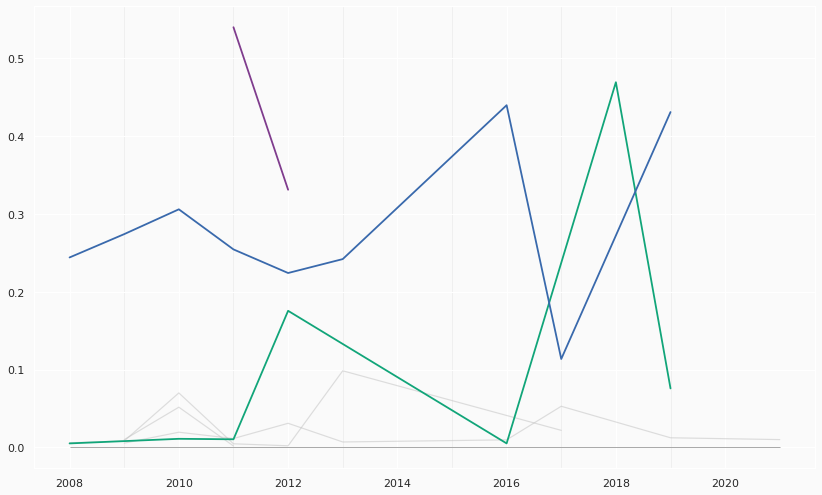

In [37]:
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 1), xmin=2008, xmax=2021, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2008, xmax=2021, color=GREY60, lw=0.8)


# Add lines ------------------------------------------------------
# Create one data frame for the highlighted countries, and other
# for non-highlighted countries.
df_highlight = var_df_v2[var_df_v2["group"] != "other"]
df_others = var_df_v2[var_df_v2["group"] == "other"]

for group in df_others["deviceType"].unique():
    data = df_others[df_others["deviceType"] == group]
    ax.plot("testYear", "failure_rate", c=GREY75, lw=1.2, alpha=0.5, data=data)

for idx, group in enumerate(df_highlight["deviceType"].unique()):
    data = df_highlight[df_highlight["deviceType"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("testYear", "failure_rate", color=color, lw=1.8, data=data)

In [38]:
# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Add titles, subtitles, and caption -----------------------------
# This uses `fig.text()` instead of regular titles to have full
# control of the text alignment.
subtitle = [
    "The line chart visualizes the performance in device types over time based on their failure rate, calculated by their total number of failures divided by their total number of tests in a given year.",
    "The device types with the greatest/most significant variance over time have been highlighted in color, while the remaining device types have been plotted in gray for comparison. As the chart", 
    "indicates, the three highlighted device types see much larger variations in performance over time than do a majority of other categories.", 
]

fig.text(
    0.08,
    0.97,
    "Highlighted Performance Variations Over Time, by Device Type",
    color=GREY10,
    fontsize=15,
    fontname="Montserrat",
    weight="bold"
)

fig.text(
    0.08,
    0.91,
    "\n".join(subtitle),
    ha="left",
    color=GREY30,
    fontname="Montserrat",
    fontsize=9,
)

Text(0.08, 0.91, 'The line chart visualizes the performance in device types over time based on their failure rate, calculated by their total number of failures divided by their total number of tests in a given year.\nThe device types with the greatest/most significant variance over time have been highlighted in color, while the remaining device types have been plotted in gray for comparison. As the chart\nindicates, the three highlighted device types see much larger variations in performance over time than do a majority of other categories.')

In [39]:
# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(2008, 2025)
ax.set_ylim(0, 0.6)

# Positions
LABEL_Y = [
    0.08, # Semicoa
    0.01, # Honeywell
    0.39  # Microsemi
    
]

x_start = 2021
x_end = 2022
PAD = 0.1

# Add labels for highlighted countries honly
for idx, group in enumerate(df_highlight["deviceType"].unique()):
    data = df_highlight[(df_highlight["deviceType"] == group) & (df_highlight["testYear"] == 2021)]
    color = COLOR_SCALE[idx]
    
    # Manufacturer name
    text1 = "Semicoa"
    text2 = "Honeywell"
    text3 = "Microsemi"
    
    text = [text1, text2, text3]
    
    # Vertical start of line
    y_start = var_df_v2["failure_rate"].values[0]
    # Vertical end of line
    y_end = LABEL_Y[idx]
    
    # Add country text
    ax.text(2022, 0.32, "Memory", color  = "#7F3C8D")
    ax.text(2022, 0.08, "Microcircuit", color = "#11A579")
    ax.text(2022, 0.42, "Transistor", color = "#3969AC")

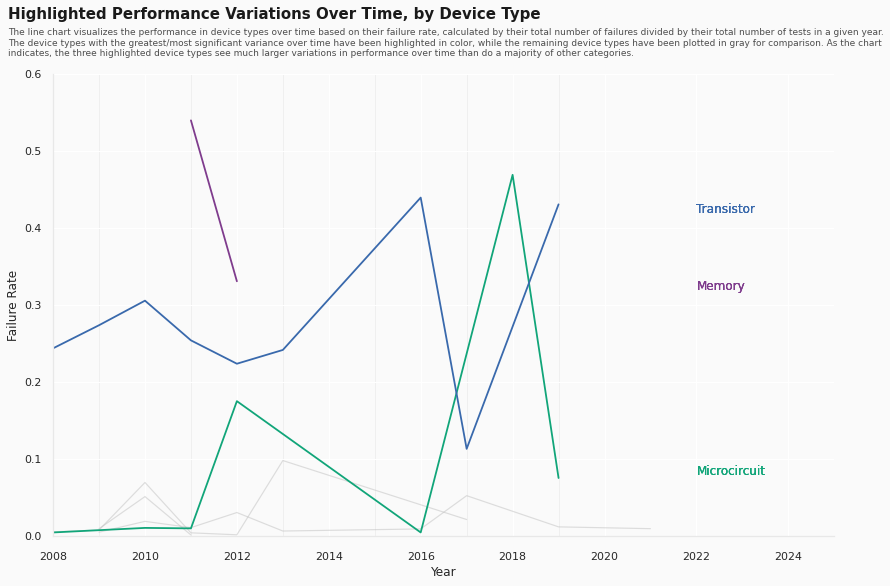

In [40]:
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Failure Rate', fontsize = 12)

fig

In [41]:
len(var_df_v2)

38

### Most Commonly Failed Tests by Category

In [42]:
datData4 = pd.DataFrame()
i = 0
datDataPath = '/home/ec2-user/SageMaker/cleaning/result_csv/datDataClean.csv'
for chunk in pd.read_csv(datDataPath, chunksize=10000):
    x = random.random()
    i += 1
    print('\ron chunk {0}'.format(i), end='')
    if x < .10:
        chunk = chunk[['drmFile', 'lot', 'sn', 'SCD', 'deviceType', 'partIsAnalog',
                       'g', 'deviceManufacturer', 'testDate', 'testType', 'ageTest']]
        chunk['deviceType'] = chunk.apply(lambda r: r['deviceType'] + ' (analog)' if r['partIsAnalog'] == 1 else r['deviceType'], axis=1)
        chunk.drop('partIsAnalog', axis=1, inplace=True)
        chunk['testYear'] = chunk['testDate'].apply(lambda x: pd.to_datetime(x).year )
        datData4 = pd.concat([datData4, chunk])
    else:
        continue
print('\n')
print('number of records loaded:', len(datData4))
datData4.head()

on chunk 897

number of records loaded: 940000


,drmFile,lot,sn,SCD,deviceType,g,deviceManufacturer,testDate,testType,ageTest,testYear
20000,GDZ036RSV-03Test-3Ctrl.dat,QLP042Ctrl,1483,5672986-101,microcircuit,G,honeywell,2019-12-09,Initial Electrical,153 days,2019
20001,GDZ036RSV-03Test-3Ctrl.dat,QLP042Ctrl,1483,5672986-101,microcircuit,G,honeywell,2019-12-09,Initial Electrical,153 days,2019
20002,GDZ036RSV-03Test-3Ctrl.dat,QLP042Ctrl,1483,5672986-101,microcircuit,G,honeywell,2019-12-09,Initial Electrical,153 days,2019
20003,GDZ036RSV-03Test-3Ctrl.dat,QLP042Ctrl,1483,5672986-101,microcircuit,G,honeywell,2019-12-09,Initial Electrical,153 days,2019
20004,GDZ036RSV-03Test-3Ctrl.dat,QLP042Ctrl,1483,5672986-101,microcircuit,G,honeywell,2019-12-09,Initial Electrical,153 days,2019


In [43]:
cur.execute('''
SELECT dat_file_name, lot_no, sn, scd_number, device_mfr, deviceType, testDate, test_type, max(failInd) as failInd
FROM 
(
    SELECT DISTINCT dat_file_name, lot_no, sn, scd_number, device_mfr, test_type,
        CASE WHEN analog_part_ind = '1' then dat_device_type||' (analog)' else dat_device_type END AS deviceType,
        CASE WHEN test_pass_ind = 'F' then 1 else 0 END AS failInd, CAST(test_dt as DATE) as testDate
    FROM "Raw"."Dat_Data_Cleansed"
) foo
GROUP BY dat_file_name, lot_no, sn, scd_number, device_mfr, deviceType, testDate, test_type
''')
datData4 = cur.fetchall()
datData4 = pd.DataFrame(datData4)
datData4.columns = ['drmFile', 'lot', 'sn', 'SCD', 'deviceManufacturer', 'deviceType', 
                    'testDate', 'testType', 'failInd']
datData4['testYear'] = datData4['testDate'].apply(lambda x: pd.to_datetime(x).year )
print('number of records loaded:', len(datData4))
datData4.head()

number of records loaded: 42514


,drmFile,lot,sn,SCD,deviceManufacturer,deviceType,testDate,testType,failInd,testYear
0,A_ATE_Data.dat,QLP015IE,158,5672969-101,honeywell,amplifier,2009-04-15,Initial Electrical,0,2009
1,A_ATE_Data.dat,QLP015IE,158,5672969-101,honeywell,amplifier,2009-04-23,Initial Electrical,0,2009
2,A_ATE_Data.dat,QLP015IE,158,5672969-101,honeywell,amplifier,2009-05-03,Initial Electrical,0,2009
3,A_ATE_Data.dat,QLP015IE,158,5672969-101,honeywell,amplifier,2009-05-12,Initial Electrical,0,2009
4,A_ATE_Data.dat,QLP015IE,158,5672969-101,honeywell,amplifier,2009-05-14,Initial Electrical,0,2009


In [44]:
datData5 = datData4[datData4['failInd'] == 1] 
# datData5.head()

In [45]:
df = datData5[['testType', 'deviceType']].value_counts().reset_index(name='fail_counts')
# df.head()

In [46]:
df2 = datData4[['testType', 'deviceType']].value_counts().reset_index(name='test_counts')
# df2.head()

In [47]:
df_tests_and_fails = pd.merge(df, df2, how='left', 
                              left_on = ['testType','deviceType'], 
                              right_on = ['testType','deviceType'])
df_tests_and_fails.head()

,testType,deviceType,fail_counts,test_counts
0,Post-TID Electrical,transistor,1269,2900
1,Post-Neutron Electrical,transistor,1173,2260
2,Initial Electrical,memory,213,399
3,Initial Electrical,transistor,176,3873
4,Pre-TID Electrical,transistor,139,256


In [48]:
df_1 = df_tests_and_fails
df_1['failure_rate'] = df_1['fail_counts']/df_1['test_counts']
df_1.head()

,testType,deviceType,fail_counts,test_counts,failure_rate
0,Post-TID Electrical,transistor,1269,2900,0.437586
1,Post-Neutron Electrical,transistor,1173,2260,0.519027
2,Initial Electrical,memory,213,399,0.533835
3,Initial Electrical,transistor,176,3873,0.045443
4,Pre-TID Electrical,transistor,139,256,0.542969


In [49]:
len(df_1)

41

In [50]:
counts = df_1.nunique()
counts

testType         9
deviceType       7
fail_counts     29
test_counts     41
failure_rate    41
dtype: int64

In [51]:
for col in df_1:
    print(df_1[col].unique())

['Post-TID Electrical' 'Post-Neutron Electrical' 'Initial Electrical'
 'Pre-TID Electrical' 'Post-Rad Electrical' 'Post-DRS Electrical'
 'Post-Delid Electrical' 'Post-SEE Electrical' 'Other Electrical']
['transistor' 'memory' 'diode' 'microcircuit' 'microcircuit (analog)'
 'amplifier (analog)' 'amplifier']
[1269 1173  213  176  139  117   86   84   70   43   34   33   32   31
   27   25   24   23   22   20   19   15   14   12   11   10    9    3
    1]
[2900 2260  399 3873  256 7082  165 2245 4173  199  424  616 2455  160
  167 1151  774 1567  267  668  884  834  820  614  156  761  238  269
  304  307   86   12   47  848  235   77   89  147   98   88  135]
[0.43758621 0.51902655 0.53383459 0.04544281 0.54296875 0.01652076
 0.52121212 0.03741648 0.0167745  0.2160804  0.08018868 0.05519481
 0.01344196 0.20625    0.19161677 0.02780191 0.04005168 0.01723038
 0.09363296 0.03742515 0.02714932 0.02757794 0.02682927 0.03257329
 0.12179487 0.01971091 0.05882353 0.04460967 0.03947368 0.03908795

In [52]:
# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'Transistor', 'crimson'],
        [1,'Memory','darkorchid'],
        [2,'Diode','darkorange'],
        [3,'Microcircuit','steelblue'],
        [4,'Microcircuit (Analog)','gold'],
        [5,'Amplifier','yellowgreen'],
        [6,'Amplifier (Analog)','lightseagreen'],
        [7,'Post-TID Electrical','crimson'],
        [8,'Post-Neutron Electrical','darkorange'],
        [9,'Initial Electrical','lightseagreen'],
        [10,'Pre-TID Electrical','gold'],
        [11,'Post-Rad Electrical','greenyellow'],
        [12,'Post-DRS Electrical','darkorchid'],
        [13,'Post-Delid Electrical','steelblue'],
        [14,'Post-SEE Electrical','mediumorchid'],
        [15,'Other Electrical','yellowgreen']]

links = [['Source','Target','Value','Link Color'],

        # Transistor
        [0,7,1269,'rgba(127, 194, 65, 0.2)'],
        [0,8,1173,'rgba(127, 194, 65, 0.2)'],
        [0,9,176,'rgba(127, 194, 65, 0.2)'],
        [0,10,139,'rgba(127, 194, 65, 0.2)'],
        [0,11,86,'rgba(127, 194, 65, 0.2)'],
        [0,13,31,'rgba(127, 194, 65, 0.2)'],
        [0,14,23,'rgba(127, 194, 65, 0.2)'],
        [0,15,19,'rgba(127, 194, 65, 0.2)'],
        [0,12,10,'rgba(127, 194, 65, 0.2)'],

        # Memory
        [1,9,213,'rgba(127, 194, 65, 0.2)'],
        [1,10,43,'rgba(127, 194, 65, 0.2)'],
        [1,13,33,'rgba(127, 194, 65, 0.2)'],
        [1,14,32,'rgba(127, 194, 65, 0.2)'],
        [1,8,11,'rgba(127, 194, 65, 0.2)'],

        # Diode
        [2,9,117,'rgba(127, 194, 65, 0.2)'],
        [2,8,70,'rgba(127, 194, 65, 0.2)'],
        [2,7,34,'rgba(127, 194, 65, 0.2)'],
        [2,11,25,'rgba(127, 194, 65, 0.2)'],
        [2,15,14,'rgba(127, 194, 65, 0.2)'],
        [2,12,9,'rgba(127, 194, 65, 0.2)'],

        # Microcircuit
        [3,9,84,'rgba(127, 194, 65, 0.2)'],
        [3,7,24,'rgba(127, 194, 65, 0.2)'],
        [3,12,22,'rgba(127, 194, 65, 0.2)'],
        [3,13,12,'rgba(127, 194, 65, 0.2)'],
        [3,14,9,'rgba(127, 194, 65, 0.2)'],
        [3,15,3,'rgba(127, 194, 65, 0.2)'],
        [3,8,1,'rgba(127, 194, 65, 0.2)'],
        [3,10,1,'rgba(127, 194, 65, 0.2)'],

        # Microcircuit (Analog)
        [4,12,34,'rgba(127, 194, 65, 0.2)'],
        [4,9,33,'rgba(127, 194, 65, 0.2)'],
        [4,11,32,'rgba(127, 194, 65, 0.2)'],
        [4,7,25,'rgba(127, 194, 65, 0.2)'],
        [4,8,20,'rgba(127, 194, 65, 0.2)'],
        [4,10,11,'rgba(127, 194, 65, 0.2)'],
        [4,15,3,'rgba(127, 194, 65, 0.2)'],

        # Amplifier
        [5,9,15,'rgba(127, 194, 65, 0.2)'],
        [5,8,12,'rgba(127, 194, 65, 0.2)'],
        [5,11,1,'rgba(127, 194, 65, 0.2)'],
        [5,12,1,'rgba(127, 194, 65, 0.2)'],
        
        # Amplifier (Analog)
        [6,9,27,'rgba(127, 194, 65, 0.2)'],
        [6,8,12,'rgba(127, 194, 65, 0.2)']]


# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
    title = "Most Commonly Failed Tests by Part Category",
    height = 772,
    font = dict(
      size = 10),)

fig = go.Figure(dict(data=[data_trace], layout=layout))
iplot(fig, validate=False)

In [53]:
fig.write_html("interactive_visuals/MostCommonlyFailedTestsByCategory.html")

### Most Commonly Failed Tests by Manufacturer

In [54]:
df = datData5[['testType', 'deviceManufacturer']].value_counts().reset_index(name='fail_counts')
# df.head()

In [55]:
df2 = datData4[['testType', 'deviceManufacturer']].value_counts().reset_index(name='test_counts')
# df2.head()

In [56]:
df_tests_and_fails = pd.merge(df, df2, how='left', 
                              left_on = ['testType','deviceManufacturer'], 
                              right_on = ['testType','deviceManufacturer'])
df_tests_and_fails.head()

,testType,deviceManufacturer,fail_counts,test_counts
0,Post-Neutron Electrical,microsemi,1087,4649
1,Post-TID Electrical,microsemi,1069,1817
2,Initial Electrical,honeywell,364,6471
3,Initial Electrical,microsemi,159,7435
4,Post-Neutron Electrical,semicoa,141,575


In [57]:
df_1 = df_tests_and_fails
df_1['failure_rate'] = df_1['fail_counts']/df_1['test_counts']
df_1.head()

,testType,deviceManufacturer,fail_counts,test_counts,failure_rate
0,Post-Neutron Electrical,microsemi,1087,4649,0.233814
1,Post-TID Electrical,microsemi,1069,1817,0.588332
2,Initial Electrical,honeywell,364,6471,0.056251
3,Initial Electrical,microsemi,159,7435,0.021385
4,Post-Neutron Electrical,semicoa,141,575,0.245217


In [58]:
len(df_1)

42

In [59]:
counts = df_1.nunique()
counts

testType               9
deviceManufacturer    12
fail_counts           33
test_counts           40
failure_rate          41
dtype: int64

In [60]:
for col in df_1:
    print(df_1[col].unique())

['Post-Neutron Electrical' 'Post-TID Electrical' 'Initial Electrical'
 'Pre-TID Electrical' 'Post-Rad Electrical' 'Post-DRS Electrical'
 'Post-Delid Electrical' 'Post-SEE Electrical' 'Other Electrical']
['microsemi' 'honeywell' 'semicoa' 'international rectifier' 'semtech'
 'osi/optoelectronics' 'raytheon' 'vishay' 'astrium' 'other' 'sensitron'
 'golden altos']
[1087 1069  364  159  141  139  107  106   79   55   52   51   49   48
   45   41   38   33   31   28   25   23   21   13   11   10    9    8
    6    5    4    2    1]
[4649 1817 6471 7435  575  230  857  445 2211 1595  216 2685  826  928
  429  402   63  264  762  679  875  822   87  318  222   39   86  722
  685  334  352   12   58  157  725   41   38   52   75    9]
[0.23381372 0.58833242 0.05625097 0.02138534 0.24521739 0.60434783
 0.12485414 0.23820225 0.03573044 0.03448276 0.24074074 0.01899441
 0.05932203 0.05172414 0.1048951  0.10199005 0.6031746  0.125
 0.04068241 0.04123711 0.02857143 0.02798054 0.24137931 0.0408805
 

In [61]:
# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'Microsemi', 'crimson'],
        [1,'Honeywell','steelblue'],
        [2,'Semicoa','darkorange'],
        [3,'International Rectifier','lightseagreen'],
        [4,'Semtech','mediumslateblue'],
        [5,'OSI/Optoelectronics','mediumorchid'],
        [6,'Raytheon','greenyellow'],
        [7,'Vishay','orangered'],
        [8,'Astrium','gold'],
        [9,'Other','yellow'],
        [10,'Sensitron','darkorchid'],
        [11,'Golden Altos','yellowgreen'],
        [12,'Post-TID Electrical','darkorange'],
        [13,'Post-Neutron Electrical','crimson'],
        [14,'Initial Electrical','lightseagreen'],
        [15,'Pre-TID Electrical','gold'],
        [16,'Post-Rad Electrical','yellowgreen'],
        [17,'Post-DRS Electrical','steelblue'],
        [18,'Post-Delid Electrical','mediumorchid'],
        [19,'Post-SEE Electrical','darkorchid'],
        [20,'Other Electrical','greenyellow']]

links = [['Source','Target','Value','Link Color'],

        # Microsemi
        [0,13,1087,'rgba(127, 194, 65, 0.2)'],
        [0,12,1069,'rgba(127, 194, 65, 0.2)'],
        [0,14,159,'rgba(127, 194, 65, 0.2)'],
        [0,15,139,'rgba(127, 194, 65, 0.2)'],
        [0,16,52,'rgba(127, 194, 65, 0.2)'],
        [0,20,33,'rgba(127, 194, 65, 0.2)'],
        [0,17,9,'rgba(127, 194, 65, 0.2)'],

        # Honeywell
        [1,14,364,'rgba(127, 194, 65, 0.2)'],
        [1,12,79,'rgba(127, 194, 65, 0.2)'],
        [1,17,51,'rgba(127, 194, 65, 0.2)'],
        [1,13,48,'rgba(127, 194, 65, 0.2)'],
        [1,18,45,'rgba(127, 194, 65, 0.2)'],
        [1,19,41,'rgba(127, 194, 65, 0.2)'],
        [1,16,28,'rgba(127, 194, 65, 0.2)'],
        [1,15,11,'rgba(127, 194, 65, 0.2)'],
        [1,20,5,'rgba(127, 194, 65, 0.2)'],

        # Semicoa
        [2,13,141,'rgba(127, 194, 65, 0.2)'],
        [2,12,106,'rgba(127, 194, 65, 0.2)'],
        [2,14,49,'rgba(127, 194, 65, 0.2)'],
        [2,16,38,'rgba(127, 194, 65, 0.2)'],
        [2,17,10,'rgba(127, 194, 65, 0.2)'],

        # International Rectifier
        [3,12,107,'rgba(127, 194, 65, 0.2)'],
        [3,14,55,'rgba(127, 194, 65, 0.2)'],
        [3,18,31,'rgba(127, 194, 65, 0.2)'],
        [3,19,23,'rgba(127, 194, 65, 0.2)'],

        # Semtech
        [4,14,25,'rgba(127, 194, 65, 0.2)'],
        [4,13,4,'rgba(127, 194, 65, 0.2)'],
        [4,12,2,'rgba(127, 194, 65, 0.2)'],

        # OSI
        [5,16,21,'rgba(127, 194, 65, 0.2)'],
        
        # Raytheon
        [6,12,13,'rgba(127, 194, 65, 0.2)'],
        [6,14,8,'rgba(127, 194, 65, 0.2)'],
        [6,13,8,'rgba(127, 194, 65, 0.2)'],
        [6,17,6,'rgba(127, 194, 65, 0.2)'],
        [6,16,5,'rgba(127, 194, 65, 0.2)'],
        [6,15,1,'rgba(127, 194, 65, 0.2)'],
        [6,20,1,'rgba(127, 194, 65, 0.2)'],

        # Vishay
        [7,13,11,'rgba(127, 194, 65, 0.2)'],
    
        # Astrium
        [8,12,11,'rgba(127, 194, 65, 0.2)'],

        # Other
        [9,12,6,'rgba(127, 194, 65, 0.2)'],
         
        # Sensitron
        [10,14,4,'rgba(127, 194, 65, 0.2)'],
        
        # Golden Altos
        [11,12,2,'rgba(127, 194, 65, 0.2)'],
        [11,14,1,'rgba(127, 194, 65, 0.2)']]


# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
    title = "Most Commonly Failed Tests by Manufacturer",
    height = 772,
    font = dict(
      size = 10),)

fig = go.Figure(dict(data=[data_trace], layout=layout))
iplot(fig, validate=False)

In [62]:
fig.write_html("interactive_visuals/MostCommonlyFailedTestsByManufacturer.html")

### Total Number of Tests by Part Category

In [63]:
datData5 = datData4[datData4['failInd'] == 1] 
# datData5.head()

In [64]:
df = datData5[['testType', 'deviceType']].value_counts().reset_index(name='fail_counts')
# df.head()

In [65]:
df2 = datData4[['testType', 'deviceType']].value_counts().reset_index(name='test_counts')
# df2.head()

In [66]:
df_tests_and_fails = pd.merge(df, df2, how='left', 
                              left_on = ['testType','deviceType'], 
                              right_on = ['testType','deviceType'])
df_tests_and_fails.head()

,testType,deviceType,fail_counts,test_counts
0,Post-TID Electrical,transistor,1269,2900
1,Post-Neutron Electrical,transistor,1173,2260
2,Initial Electrical,memory,213,399
3,Initial Electrical,transistor,176,3873
4,Pre-TID Electrical,transistor,139,256


In [67]:
df_1 = df_tests_and_fails
df_1['failure_rate'] = df_1['fail_counts']/df_1['test_counts']
df_1.head()

,testType,deviceType,fail_counts,test_counts,failure_rate
0,Post-TID Electrical,transistor,1269,2900,0.437586
1,Post-Neutron Electrical,transistor,1173,2260,0.519027
2,Initial Electrical,memory,213,399,0.533835
3,Initial Electrical,transistor,176,3873,0.045443
4,Pre-TID Electrical,transistor,139,256,0.542969


In [69]:
# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'Transistor', 'yellowgreen'],
        [1,'Memory','darkorchid'],
        [2,'Diode','darkorange'],
        [3,'Microcircuit','lightseagreen'],
        [4,'Microcircuit (Analog)','steelblue'],
        [5,'Amplifier','gold'],
        [6,'Amplifier (Analog)','crimson'],
        [7,'Post-TID Electrical','greenyellow'],
        [8,'Post-Neutron Electrical','darkorange'],
        [9,'Initial Electrical','crimson'],
        [10,'Pre-TID Electrical','darkorchid'],
        [11,'Post-Rad Electrical','mediumorchid'],
        [12,'Post-DRS Electrical','yellowgreen'],
        [13,'Post-Delid Electrical','steelblue'],
        [14,'Post-SEE Electrical','lightseagreen'],
        [15,'Other Electrical','gold']]

links = [['Source','Target','Value','Link Color'],

        # Transistor
        [0,7,2900,'rgba(127, 194, 65, 0.2)'],
        [0,8,2260,'rgba(127, 194, 65, 0.2)'],
        [0,9,3873,'rgba(127, 194, 65, 0.2)'],
        [0,10,256,'rgba(127, 194, 65, 0.2)'],
        [0,11,165,'rgba(127, 194, 65, 0.2)'],
        [0,13,774,'rgba(127, 194, 65, 0.2)'],
        [0,14,834,'rgba(127, 194, 65, 0.2)'],
        [0,15,156,'rgba(127, 194, 65, 0.2)'],
        [0,12,47,'rgba(127, 194, 65, 0.2)'],

        # Memory
        [1,9,399,'rgba(127, 194, 65, 0.2)'],
        [1,10,199,'rgba(127, 194, 65, 0.2)'],
        [1,13,160,'rgba(127, 194, 65, 0.2)'],
        [1,14,167,'rgba(127, 194, 65, 0.2)'],
        [1,8,12,'rgba(127, 194, 65, 0.2)'],

        # Diode
        [2,9,7082,'rgba(127, 194, 65, 0.2)'],
        [2,8,4173,'rgba(127, 194, 65, 0.2)'],
        [2,7,424,'rgba(127, 194, 65, 0.2)'],
        [2,11,267,'rgba(127, 194, 65, 0.2)'],
        [2,15,238,'rgba(127, 194, 65, 0.2)'],
        [2,12,848,'rgba(127, 194, 65, 0.2)'],

        # Microcircuit
        [3,9,2245,'rgba(127, 194, 65, 0.2)'],
        [3,7,884,'rgba(127, 194, 65, 0.2)'],
        [3,12,820,'rgba(127, 194, 65, 0.2)'],
        [3,13,269,'rgba(127, 194, 65, 0.2)'],
        [3,14,235,'rgba(127, 194, 65, 0.2)'],
        [3,15,89,'rgba(127, 194, 65, 0.2)'],
        [3,8,98,'rgba(127, 194, 65, 0.2)'],
        [3,10,135,'rgba(127, 194, 65, 0.2)'],

        # Microcircuit (Analog)
        [4,12,616,'rgba(127, 194, 65, 0.2)'],
        [4,9,2455,'rgba(127, 194, 65, 0.2)'],
        [4,11,1151,'rgba(127, 194, 65, 0.2)'],
        [4,7,668,'rgba(127, 194, 65, 0.2)'],
        [4,8,614,'rgba(127, 194, 65, 0.2)'],
        [4,10,86,'rgba(127, 194, 65, 0.2)'],
        [4,15,77,'rgba(127, 194, 65, 0.2)'],

        # Amplifier
        [5,9,761,'rgba(127, 194, 65, 0.2)'],
        [5,8,304,'rgba(127, 194, 65, 0.2)'],
        [5,11,88,'rgba(127, 194, 65, 0.2)'],
        [5,12,147,'rgba(127, 194, 65, 0.2)'],
        
        # Amplifier (Analog)
        [6,9,1567,'rgba(127, 194, 65, 0.2)'],
        [6,8,307,'rgba(127, 194, 65, 0.2)']]


# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
    title = "Total Number of Tests by Part Category",
    height = 772,
    font = dict(
      size = 10),)

fig = go.Figure(dict(data=[data_trace], layout=layout))
iplot(fig, validate=False)

In [70]:
fig.write_html("interactive_visuals/TotalNumberofTestsByPartCategory.html")

### Total Number of Tests by Manufacturer

In [71]:
df = datData5[['testType', 'deviceManufacturer']].value_counts().reset_index(name='fail_counts')
# df.head()

In [72]:
df2 = datData4[['testType', 'deviceManufacturer']].value_counts().reset_index(name='test_counts')
# df2.head()

In [73]:
df_tests_and_fails = pd.merge(df, df2, how='left', 
                              left_on = ['testType','deviceManufacturer'], 
                              right_on = ['testType','deviceManufacturer'])
df_tests_and_fails.head()

,testType,deviceManufacturer,fail_counts,test_counts
0,Post-Neutron Electrical,microsemi,1087,4649
1,Post-TID Electrical,microsemi,1069,1817
2,Initial Electrical,honeywell,364,6471
3,Initial Electrical,microsemi,159,7435
4,Post-Neutron Electrical,semicoa,141,575


In [74]:
df_1 = df_tests_and_fails
df_1['failure_rate'] = df_1['fail_counts']/df_1['test_counts']
df_1.head()

,testType,deviceManufacturer,fail_counts,test_counts,failure_rate
0,Post-Neutron Electrical,microsemi,1087,4649,0.233814
1,Post-TID Electrical,microsemi,1069,1817,0.588332
2,Initial Electrical,honeywell,364,6471,0.056251
3,Initial Electrical,microsemi,159,7435,0.021385
4,Post-Neutron Electrical,semicoa,141,575,0.245217


In [76]:
# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'Microsemi', 'orangered'],
        [1,'Honeywell','greenyellow'],
        [2,'Semicoa','yellow'],
        [3,'International Rectifier','steelblue'],
        [4,'Semtech','darkorange'],
        [5,'OSI/Optoelectronics','darkorchid'],
        [6,'Raytheon','yellowgreen'],
        [7,'Vishay','crimson'],
        [8,'Astrium','mediumslateblue'],
        [9,'Other','mediumorchid'],
        [10,'Sensitron','gold'],
        [11,'Golden Altos','lightseagreen'],
        [12,'Post-TID Electrical','yellowgreen'],
        [13,'Post-Neutron Electrical','crimson'],
        [14,'Initial Electrical','darkorange'],
        [15,'Pre-TID Electrical','greenyellow'],
        [16,'Post-Rad Electrical','steelblue'],
        [17,'Post-DRS Electrical','lightseagreen'],
        [18,'Post-Delid Electrical','mediumorchid'],
        [19,'Post-SEE Electrical','darkorchid'],
        [20,'Other Electrical','gold']]

links = [['Source','Target','Value','Link Color'],

        # Microsemi
        [0,13,4649,'rgba(127, 194, 65, 0.2)'],
        [0,12,1817,'rgba(127, 194, 65, 0.2)'],
        [0,14,7435,'rgba(127, 194, 65, 0.2)'],
        [0,15,230,'rgba(127, 194, 65, 0.2)'],
        [0,16,216,'rgba(127, 194, 65, 0.2)'],
        [0,20,264,'rgba(127, 194, 65, 0.2)'],
        [0,17,722,'rgba(127, 194, 65, 0.2)'],

        # Honeywell
        [1,14,6471,'rgba(127, 194, 65, 0.2)'],
        [1,12,2211,'rgba(127, 194, 65, 0.2)'],
        [1,17,2685,'rgba(127, 194, 65, 0.2)'],
        [1,13,928,'rgba(127, 194, 65, 0.2)'],
        [1,18,429,'rgba(127, 194, 65, 0.2)'],
        [1,19,402,'rgba(127, 194, 65, 0.2)'],
        [1,16,679,'rgba(127, 194, 65, 0.2)'],
        [1,15,222,'rgba(127, 194, 65, 0.2)'],
        [1,20,157,'rgba(127, 194, 65, 0.2)'],

        # Semicoa
        [2,13,575,'rgba(127, 194, 65, 0.2)'],
        [2,12,445,'rgba(127, 194, 65, 0.2)'],
        [2,14,826,'rgba(127, 194, 65, 0.2)'],
        [2,16,63,'rgba(127, 194, 65, 0.2)'],
        [2,17,86,'rgba(127, 194, 65, 0.2)'],

        # International Rectifier
        [3,12,857,'rgba(127, 194, 65, 0.2)'],
        [3,14,1595,'rgba(127, 194, 65, 0.2)'],
        [3,18,762,'rgba(127, 194, 65, 0.2)'],
        [3,19,822,'rgba(127, 194, 65, 0.2)'],

        # Semtech
        [4,14,875,'rgba(127, 194, 65, 0.2)'],
        [4,13,725,'rgba(127, 194, 65, 0.2)'],
        [4,12,38,'rgba(127, 194, 65, 0.2)'],

        # OSI
        [5,16,87,'rgba(127, 194, 65, 0.2)'],
        
        # Raytheon
        [6,12,318,'rgba(127, 194, 65, 0.2)'],
        [6,14,685,'rgba(127, 194, 65, 0.2)'],
        [6,13,334,'rgba(127, 194, 65, 0.2)'],
        [6,17,352,'rgba(127, 194, 65, 0.2)'],
        [6,16,58,'rgba(127, 194, 65, 0.2)'],
        [6,15,75,'rgba(127, 194, 65, 0.2)'],
        [6,20,9,'rgba(127, 194, 65, 0.2)'],

        # Vishay
        [7,13,39,'rgba(127, 194, 65, 0.2)'],
    
        # Astrium
        [8,12,39,'rgba(127, 194, 65, 0.2)'],

        # Other
        [9,12,12,'rgba(127, 194, 65, 0.2)'],
         
        # Sensitron
        [10,14,41,'rgba(127, 194, 65, 0.2)'],
        
        # Golden Altos
        [11,12,52,'rgba(127, 194, 65, 0.2)'],
        [11,14,52,'rgba(127, 194, 65, 0.2)']]


# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
    title = "Total Number of Tests by Manufacturer",
    height = 772,
    font = dict(
      size = 10),)

fig = go.Figure(dict(data=[data_trace], layout=layout))
iplot(fig, validate=False)

In [77]:
fig.write_html("interactive_visuals/TotalNumberofTestsByManufacturer.html")

### Unique Temperature Values

In [78]:
cur.execute('''
SELECT temp
FROM "Raw"."Dat_Data_Cleansed"
''')
datData6 = cur.fetchall()
datData6 = pd.DataFrame(datData6)
datData6.columns = ['temp']
print('number of records loaded:', len(datData6))
datData6.head()

number of records loaded: 8961111


,temp
0,100
1,100
2,100
3,100
4,100


In [79]:
counts = datData6.nunique()
counts

temp    19
dtype: int64

In [80]:
temp_counts = pd.DataFrame(datData6.value_counts().reset_index(name='count'))
temp_counts

In [82]:
temp_counts['percent'] = ((temp_counts['count']/8961111) * 100)
temp_counts['total'] = 100
temp_counts

,temp,count,percent,total
0,amb,8299373,92.615447,100
1,125,326238,3.640598,100
2,-5,325818,3.635911,100
3,25,6108,0.068161,100
4,100,1163,0.012978,100
5,150,912,0.010177,100
6,nan,373,0.004162,100
7,71c,248,0.002768,100
8,71,202,0.002254,100
9,74,192,0.002143,100


In [83]:
temp_counts = temp_counts.head(3)
temp_counts

,temp,count,percent,total
0,amb,8299373,92.615447,100
1,125,326238,3.640598,100
2,-5,325818,3.635911,100


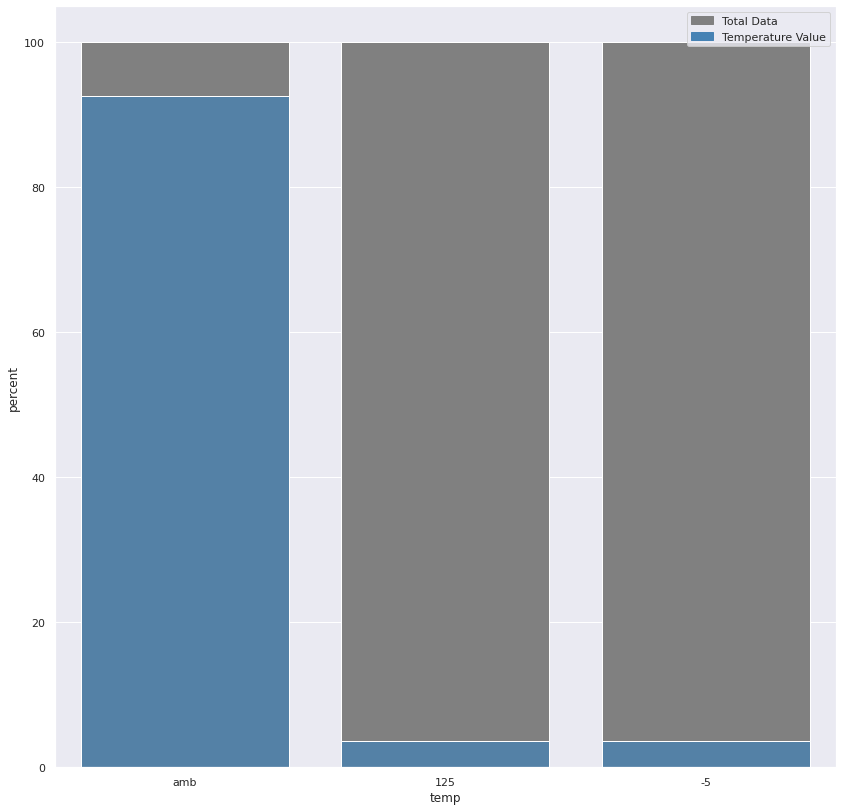

In [84]:
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 14))
bar1 = sns.barplot(x="temp",  y="total", data=temp_counts, color='gray')
bar2 = sns.barplot(x="temp", y="percent", data=temp_counts, color='steelblue')

top_bar = mpatches.Patch(color='gray', label='Total Data')
bottom_bar = mpatches.Patch(color='steelblue', label='Temperature Value')
plt.legend(handles=[top_bar, bottom_bar])

plt.show()

### Performance Variation by Manufacturer & Category

In [85]:
df = datData3[['testYear', 'deviceManufacturer', 'deviceType']].value_counts().reset_index(name='fail_counts')
# df.head()

In [86]:
df2 = datData2[['testYear', 'deviceManufacturer', 'deviceType']].value_counts().reset_index(name='test_counts')
# df2.head()

In [87]:
df_tests_and_fails = pd.merge(df, df2, how='left', 
                              left_on = ['testYear','deviceManufacturer', 'deviceType'], 
                              right_on = ['testYear','deviceManufacturer', 'deviceType'])
# df_tests_and_fails.head()

In [88]:
df_1 = df_tests_and_fails
df_1['failure_rate'] = df_1['fail_counts']/df_1['test_counts']

df_1['deviceManufacturer'].unique()

array(['microsemi', 'honeywell', 'semicoa', 'international rectifier',
       'semtech', 'osi/optoelectronics', 'raytheon', 'vishay', 'astrium',
       'other', 'sensitron', 'golden altos'], dtype=object)

Text(0.5, 1.0, 'Microsemi Diodes')

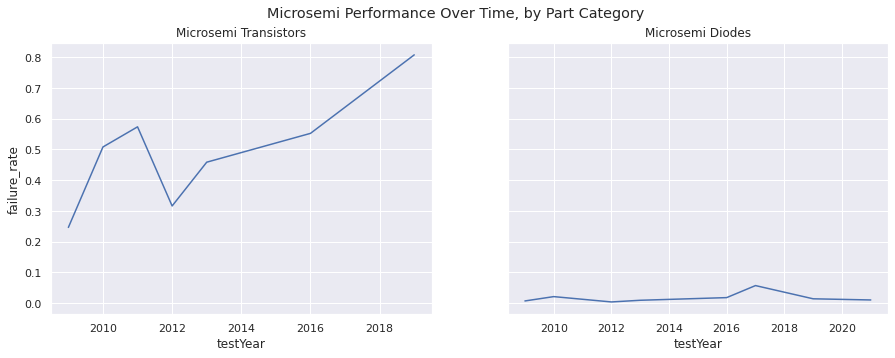

In [89]:
Microsemi_df = df_1[df_1['deviceManufacturer']=='microsemi']

microsemi_transistors = Microsemi_df[Microsemi_df['deviceType'] == 'transistor']
microsemi_diodes = Microsemi_df[Microsemi_df['deviceType'] == 'diode']

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Microsemi Performance Over Time, by Part Category')

# Transistors
sns.lineplot(ax=axes[0], x='testYear', y='failure_rate', data=microsemi_transistors)
axes[0].set_title('Microsemi Transistors')

# Diodes
sns.lineplot(ax=axes[1], x='testYear', y='failure_rate', data=microsemi_diodes)
axes[1].set_title('Microsemi Diodes')

Text(0.5, 1.0, 'Honeywell Amplifier')

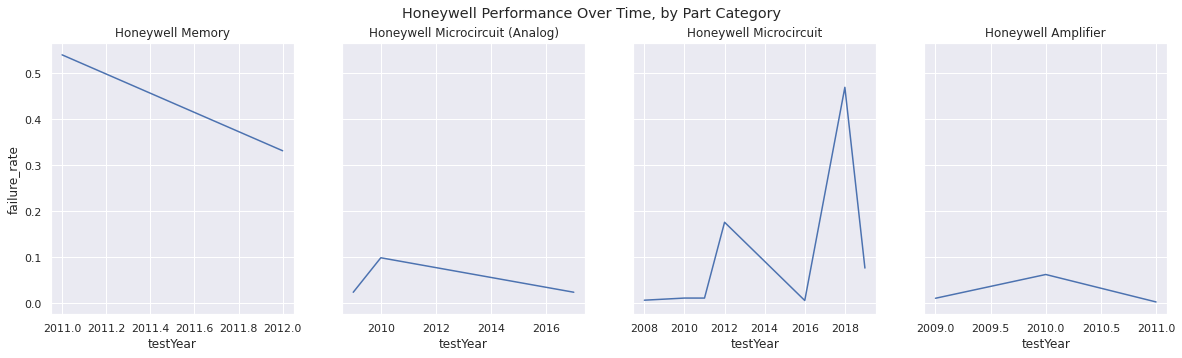

In [90]:
honeywell_df = df_1[df_1['deviceManufacturer']=='honeywell']

honeywell_memory = honeywell_df[honeywell_df['deviceType'] == 'memory']
honeywell_microcircuitanalog = honeywell_df[honeywell_df['deviceType'] == 'microcircuit (analog)']
honeywell_microcircuit = honeywell_df[honeywell_df['deviceType'] == 'microcircuit']
honeywell_amplifier = honeywell_df[honeywell_df['deviceType'] == 'amplifier']

# Amplifier (Analog) negated because only one observation, nothing to trend over time


fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.suptitle('Honeywell Performance Over Time, by Part Category')

# Memory
sns.lineplot(ax=axes[0], x='testYear', y='failure_rate', data=honeywell_memory)
axes[0].set_title('Honeywell Memory')

# Microcircuit (Analog)
sns.lineplot(ax=axes[1], x='testYear', y='failure_rate', data=honeywell_microcircuitanalog)
axes[1].set_title('Honeywell Microcircuit (Analog)')

# Microcircuit
sns.lineplot(ax=axes[2], x='testYear', y='failure_rate', data=honeywell_microcircuit)
axes[2].set_title('Honeywell Microcircuit')

# Amplifier
sns.lineplot(ax=axes[3], x='testYear', y='failure_rate', data=honeywell_amplifier)
axes[3].set_title('Honeywell Amplifier')

Text(0.5, 1.0, 'Semicoa Transistors')

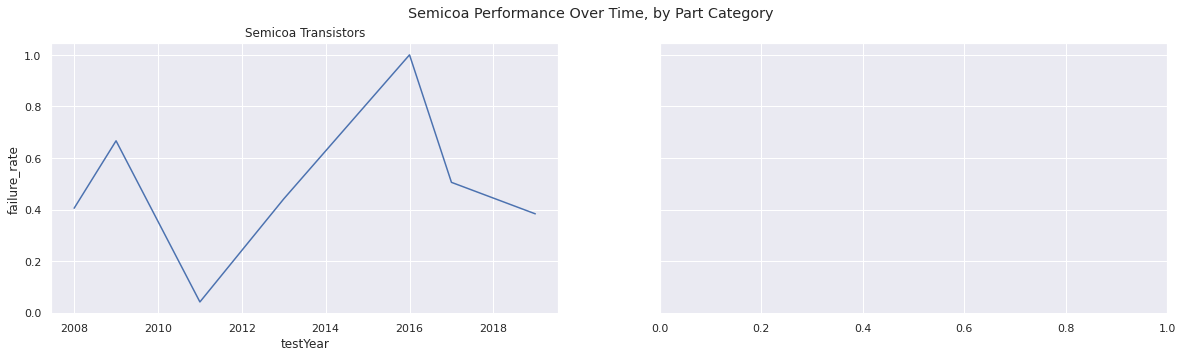

In [91]:
semicoa_df = df_1[df_1['deviceManufacturer']=='semicoa']

semicoa_transistors = semicoa_df[semicoa_df['deviceType'] == 'transistor']


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Semicoa Performance Over Time, by Part Category')

# Transistors
sns.lineplot(ax=axes[0], x='testYear', y='failure_rate', data=semicoa_df)
axes[0].set_title('Semicoa Transistors')

Text(0.5, 1.0, 'International Rectifier Transistors')

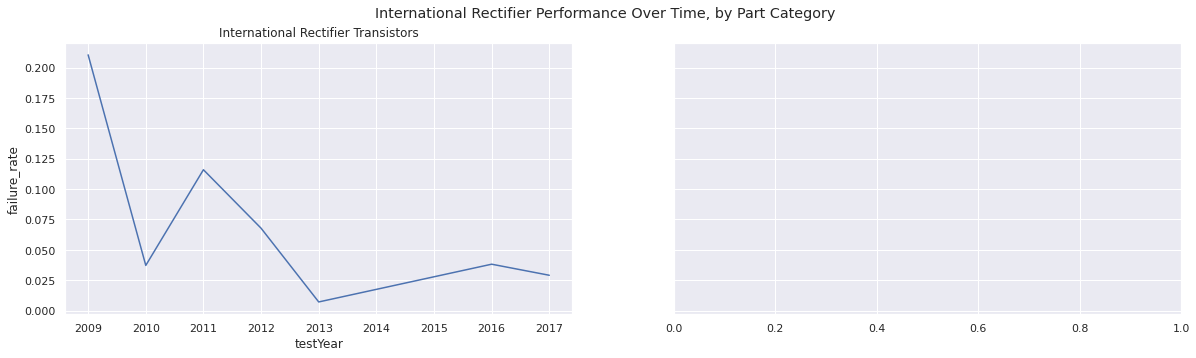

In [92]:
IR_df = df_1[df_1['deviceManufacturer']=='international rectifier']

IR_transistors = IR_df[IR_df['deviceType'] == 'transistor']


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('International Rectifier Performance Over Time, by Part Category')

# Transistors
sns.lineplot(ax=axes[0], x='testYear', y='failure_rate', data=IR_transistors)
axes[0].set_title('International Rectifier Transistors')

Text(0.5, 1.0, 'Semtech Diodes')

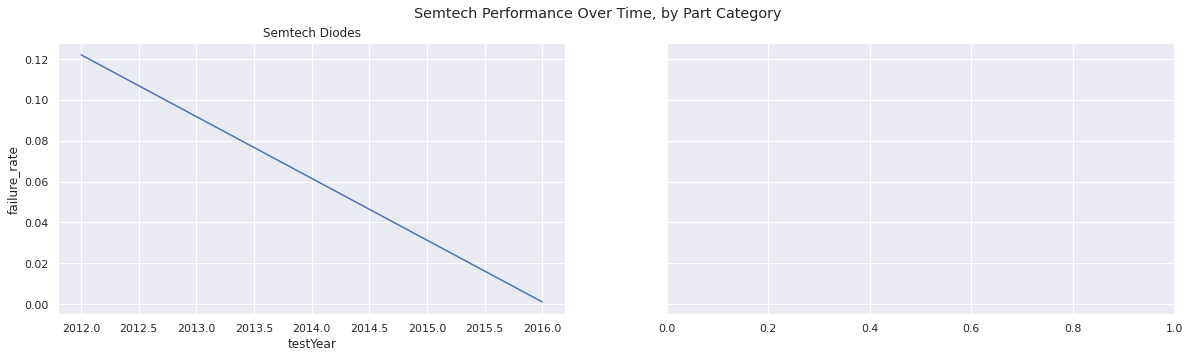

In [93]:
semtech_df = df_1[df_1['deviceManufacturer']=='semtech']

semtech_diodes = semtech_df[semtech_df['deviceType'] == 'diode']


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Semtech Performance Over Time, by Part Category')

# Transistors
sns.lineplot(ax=axes[0], x='testYear', y='failure_rate', data=semtech_diodes)
axes[0].set_title('Semtech Diodes')

In [94]:
OSI_df = df_1[df_1['deviceManufacturer']=='osi/optoelectronics']

# OSI omitted because only one observation, nothing to trend over time

Text(0.5, 1.0, 'Raytheon Microcircuit (Analog)')

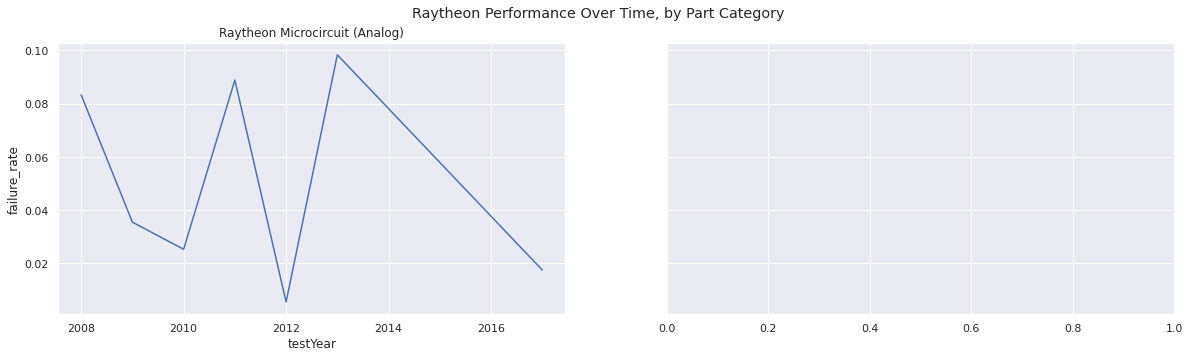

In [95]:
raytheon_df = df_1[df_1['deviceManufacturer']=='raytheon']

raytheon_microcircuitanalog = raytheon_df[raytheon_df['deviceType'] == 'microcircuit (analog)']


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Raytheon Performance Over Time, by Part Category')

# Transistors
sns.lineplot(ax=axes[0], x='testYear', y='failure_rate', data=raytheon_microcircuitanalog)
axes[0].set_title('Raytheon Microcircuit (Analog)')

In [96]:
vishay_df = df_1[df_1['deviceManufacturer']=='vishay']

# Vishay omitted because only one observation, nothing to trend over time

In [97]:
astrium_df = df_1[df_1['deviceManufacturer']=='astrium']

# Astrium omitted because only one observation, nothing to trend over time

In [98]:
other_df = df_1[df_1['deviceManufacturer']=='other']

# Other omitted because only one observation, nothing to trend over time

In [99]:
sensitron_df = df_1[df_1['deviceManufacturer']=='sensitron']

# Sensitron omitted because only one observation, nothing to trend over time

Text(0.5, 1.0, 'Golden Altos Transistors')

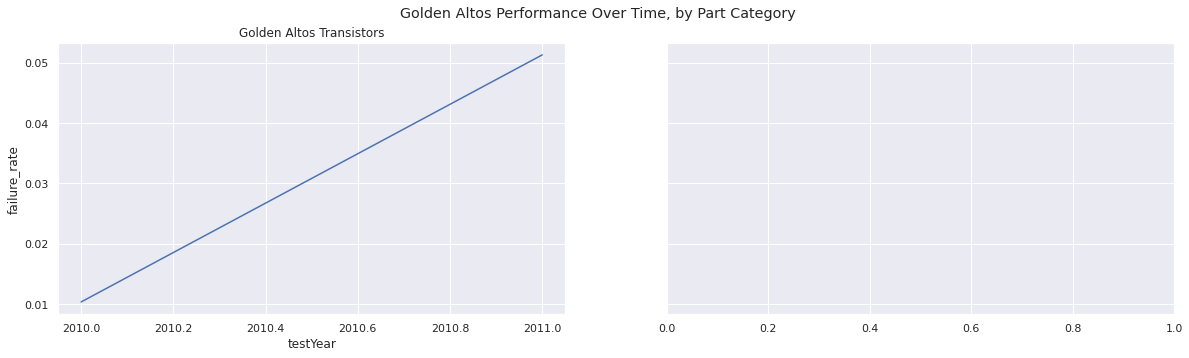

In [100]:
GA_df = df_1[df_1['deviceManufacturer']=='golden altos']


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Golden Altos Performance Over Time, by Part Category')

# Transistors
sns.lineplot(ax=axes[0], x='testYear', y='failure_rate', data=GA_df)
axes[0].set_title('Golden Altos Transistors')